In [1]:
import _base_path
import pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from resources.data_io import load_mappings
from resources.metrics import ConfusionMatrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from typing import Union, Iterable

Setting base bath to "c:\Users\Korbi\Documents\Uni\PhD\23-10_ConformalPrompting\code"


In [2]:
DATA      = 'incidents'
MODELS    = [
    'bow-rnd',
    'bow-sup',
    'bow-lr',
    'bow-svm',
    'tf-idf-lr',
    'tf-idf-svm',
    'roberta-base',
    'xlm-roberta-base'
]
LABEL     = 'product'
CV_SPLITS = [0]#, 1, 2, 3, 4]

# Load Class-Mappings:

In [3]:
class_map = load_mappings(f"../data/{DATA}/splits/", LABEL)
class_map

array(['adobo seasoning', 'after dinner mints', 'alcoholic beverages',
       ...,
       'yoghurt-like soya-based products containing bacteria cultures',
       'yogurt raisins', 'zomi and palm oil'], dtype='<U70')

In [4]:
with open('../data/incidents/support_zones.json', 'r') as file:
    high_support, low_support = json.load(file)[LABEL]

In [5]:
high_support

['ice cream',
 'cheese',
 'cookies',
 'ground beef',
 'ready to eat - cook meals',
 'sausage',
 'chilled chicken salad',
 'cakes',
 'milk',
 'bread',
 'biscuits',
 'sandwiches',
 'ham',
 'dark chocolates',
 'pork sausage',
 'potato chips',
 'chocolate bars',
 'peanut butter',
 'chicken preparations',
 'smoked salmon',
 'sauce',
 'chocolate products',
 'salami',
 'dietary supplement',
 'beef',
 'salad',
 'frozen chicken nuggets',
 'chicken',
 'beef products',
 'cake',
 'flour',
 'tahini',
 'beer',
 'ready to eat meal',
 'raw beef meat',
 'salads',
 'enoki mushrooms',
 'eggs',
 'breaded chicken',
 'food supplement',
 'candy',
 'pistachios',
 'chocolate',
 'snacks (various)',
 'yoghurt',
 'crackers',
 'oysters',
 'bakery products',
 'noodles',
 'beef jerky',
 'cooked chicken',
 'pet feed',
 'breakfast cereals',
 'bars',
 'sunflower kernels',
 'snack mix',
 'sauces',
 'dumplings',
 'pig meat - pork',
 'frozen pizza',
 'potato salad',
 'milk chocolates',
 'onions',
 'prepared dish',
 'prote

In [6]:
low_support

['smoked trout',
 'chilli powder',
 'semi-soft cheese',
 'jelly',
 'sesame sauce',
 'macaroni and cheese',
 'poultry',
 'fresh pork',
 'oats',
 'poultry meat and poultry meat products',
 'cumin powder',
 'potato croquettes',
 'mustard',
 'porridge',
 'mozzarella cheese',
 'frozen burgers',
 'frozen chicken wings',
 'chicken soup',
 'dairy products',
 'dairy dessert',
 'chicken eggs',
 'nuts mix',
 'dried coconut',
 'dried shrimp noodles',
 'dried beef meat',
 'noodle soup',
 'non-alcoholic beer',
 'fennel seeds',
 'chicken caesar wrap',
 'chicken dippers',
 'flaxseed',
 'natural mineral water',
 'mini jelly cups',
 'precooked cooked beef meat products',
 'fresh cheese',
 'frozen dumplings with pork',
 'chocolate and chocolate products',
 'corn snacks',
 'margarine',
 'infant formulae powder',
 'iced tea',
 'hot dog sausages',
 'hemp protein powder',
 'guacamole',
 'ground egusi (melon seeds)',
 'juice drink',
 'chorizo sausage',
 'chutneys',
 'gravy mix',
 'clams',
 'yogurt raisins',
 

In [7]:
counts = pd.read_csv('../data/incidents/incidents_final.csv')[LABEL].value_counts()

class_map = list(zip(
    class_map,
    range(len(class_map)),
    [counts[c] if c in counts else 0 for c in class_map]
))
class_map.sort(key=lambda row:row[2], reverse=True)
class_map

[('ice cream', 1042, 232),
 ('cheese', 279, 101),
 ('cookies', 499, 74),
 ('ground beef', 985, 72),
 ('sausage', 1576, 70),
 ('ready to eat - cook meals', 1488, 69),
 ('chilled chicken salad', 347, 54),
 ('cakes', 201, 53),
 ('biscuits', 112, 47),
 ('bread', 163, 47),
 ('milk', 1163, 47),
 ('sandwiches', 1568, 46),
 ('ham', 1000, 43),
 ('dark chocolates', 575, 39),
 ('pork sausage', 1392, 39),
 ('potato chips', 1397, 39),
 ('peanut butter', 1320, 37),
 ('chicken preparations', 325, 36),
 ('chocolate bars', 400, 36),
 ('smoked salmon', 1642, 36),
 ('chocolate products', 421, 35),
 ('sauce', 1571, 35),
 ('beef', 85, 33),
 ('dietary supplement', 587, 33),
 ('salad', 1547, 33),
 ('salami', 1552, 33),
 ('beef products', 94, 32),
 ('frozen chicken nuggets', 792, 32),
 ('flour', 717, 31),
 ('beer', 102, 30),
 ('cake', 197, 30),
 ('chicken', 302, 30),
 ('tahini', 1741, 30),
 ('raw beef meat', 1463, 29),
 ('ready to eat meal', 1489, 29),
 ('salads', 1551, 28),
 ('eggs', 672, 27),
 ('enoki mushr

# Load Results:

In [8]:
results = {}

for m in MODELS:
    r = []
    try:
        for i in CV_SPLITS:
            with open(f'{m}/{m}-{LABEL}-{i:d}.pickle', 'rb') as f:
                r.append(pickle.load(f))
    except FileNotFoundError: continue
    results[m] = r

In [9]:
def calculate_metrics(classes=[c for c, _, _ in class_map]):
    metrics = {}

    for m in results:
        f1        = []
        recall    = []
        precision = []
        accuracy  = []

        idx = [i for c, i, _ in class_map if c in classes]
        for r in results[m]:
            y_true = (r['labels'][:,idx]).astype(int)
            y_pred = (r['predictions'][:,idx] > .5).astype(int)

            f1.append(f1_score(y_true, y_pred, average='macro'))
            recall.append(recall_score(y_true, y_pred, average='macro'))
            precision.append(precision_score(y_true, y_pred, average='macro'))
            #accuracy.append(sum(y_true == y_pred) / len(y_true))
            accuracy.append(accuracy_score(y_true, y_pred))

        metrics[m] = {
            'f1':        (np.mean(f1), np.std(f1)),
            'recall':    (np.mean(recall), np.std(recall)),
            'precision': (np.mean(precision), np.std(precision)),
            'accuracy':  (np.mean(accuracy), np.std(accuracy))
        }
    return metrics

In [10]:
metrics_all = calculate_metrics()
metrics_high_support = calculate_metrics(high_support)
metrics_low_support = calculate_metrics(low_support)

C:\Users\Korbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\Korbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Korbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: Undefine

In [11]:
def print_table(metrics:Iterable[str] = ['f1', 'accuracy']):
    for model in MODELS:
        row =  f'{model.upper()} &\n'

        if model in metrics_all:
            row += ' & '.join([f'${metrics_all[model][metric][0]:.2f} \pm {metrics_all[model][metric][1]:.2f}$' for metric in metrics])
        else:
            row += ' &'*(len(metrics)-1)
            
        row += ' &\n'

        if model in metrics_high_support:
            row += ' & '.join([f'${metrics_high_support[model][metric][0]:.2f} \pm {metrics_high_support[model][metric][1]:.2f}$' for metric in metrics])
        else:
            row += ' &'*(len(metrics)-1)

        row += ' &\n'
        

        if model in metrics_high_support:
            row += ' & '.join([f'${metrics_low_support[model][metric][0]:.2f} \pm {metrics_low_support[model][metric][1]:.2f}$' for metric in metrics])
        else:
            row += ' &'*(len(metrics)-1)
        row += ' \\\\\n'
        print(row)

In [12]:
print_table()

BOW-RND &
$0.00 \pm 0.00$ & $0.00 \pm 0.00$ &
$0.01 \pm 0.00$ & $0.00 \pm 0.00$ &
$0.00 \pm 0.00$ & $0.00 \pm 0.00$ \\

BOW-SUP &
$0.00 \pm 0.00$ & $0.03 \pm 0.00$ &
$0.00 \pm 0.00$ & $0.03 \pm 0.00$ &
$0.00 \pm 0.00$ & $0.67 \pm 0.00$ \\

BOW-LR &
$0.06 \pm 0.00$ & $0.26 \pm 0.00$ &
$0.34 \pm 0.00$ & $0.44 \pm 0.00$ &
$0.01 \pm 0.00$ & $0.65 \pm 0.00$ \\

BOW-SVM &
$0.07 \pm 0.00$ & $0.30 \pm 0.00$ &
$0.31 \pm 0.00$ & $0.48 \pm 0.00$ &
$0.02 \pm 0.00$ & $0.63 \pm 0.00$ \\

TF-IDF-LR &
$0.02 \pm 0.00$ & $0.16 \pm 0.00$ &
$0.16 \pm 0.00$ & $0.22 \pm 0.00$ &
$0.00 \pm 0.00$ & $0.67 \pm 0.00$ \\

TF-IDF-SVM &
$0.04 \pm 0.00$ & $0.21 \pm 0.00$ &
$0.23 \pm 0.00$ & $0.35 \pm 0.00$ &
$0.01 \pm 0.00$ & $0.60 \pm 0.00$ \\

ROBERTA-BASE &
$0.00 \pm 0.00$ & $0.00 \pm 0.00$ &
$0.04 \pm 0.00$ & $0.03 \pm 0.00$ &
$0.00 \pm 0.00$ & $0.16 \pm 0.00$ \\

XLM-ROBERTA-BASE &
$0.00 \pm 0.00$ & $0.01 \pm 0.00$ &
$0.02 \pm 0.00$ & $0.01 \pm 0.00$ &
$0.00 \pm 0.00$ & $0.13 \pm 0.00$ \\



# Plot confusion matrix

In [13]:
hs_mask = np.zeros(len(class_map), dtype=bool)
ls_mask = np.zeros(len(class_map), dtype=bool)
ms_mask = np.zeros(len(class_map), dtype=bool)

for c, i, _ in class_map:
    hs_mask[i] = c in high_support
    ls_mask[i] = c in low_support
    ms_mask[i] = not(hs_mask[i] or ls_mask[i])
        
y_pred = np.array([
    np.argmax([e[hs_mask].max(), e[ms_mask].max(), e[ls_mask].max()])
    for e in results['bow-svm'][0]['predictions']
])
y_true = np.array([
    np.argmax([e[hs_mask].max(), e[ms_mask].max(), e[ls_mask].max()])
    for e in results['bow-svm'][0]['labels']
])

cm = ConfusionMatrix(y_true, y_pred, classes=["High", "Medium", "Low"])

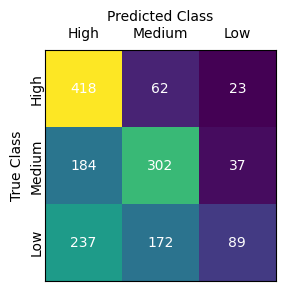

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
cm.plot(axs)
fig.savefig(f'../pictures/plots/cm_bow-svm_{LABEL}.pdf')